In [1]:
import numpy as np     #只需要下载numpy库即可
import random
import GridWorld_v3
from draw import draw  #绘图函数
from ExperienceReplayBuffer import ExperienceReplayBuffer
import tqdm

In [2]:
rows = 5      #记得行数和列数这里要同步改
columns = 5
gridworld = GridWorld_v3.GridWorld_v3(forbiddenAreaScore=-10, score=1,desc = [".....",".##..","..#..",".#T#.",".#..."]) 
gridworld.show()
trajectorySteps = 1000

⬜️⬜️⬜️⬜️⬜️
⬜️🚫🚫⬜️⬜️
⬜️⬜️🚫⬜️⬜️
⬜️🚫✅🚫⬜️
⬜️🚫⬜️⬜️⬜️


In [3]:
state_values = np.array([random.random() for i in range(25)])
learning_rate = 0.01
gamma = 0.99

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.fc1 = nn.Linear(2,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,5)  #拟合的Action value，5个输出
    def forward(self, state):
        h1 = self.fc1(state)
        h1 = F.relu(h1)
        h2 = self.fc2(h1)
        h2 = F.relu(h2)
        Q = self.fc3(h2)
        return Q
        

In [5]:
experiencePool = ExperienceReplayBuffer(max_size=10000)
policy = 0.2 * np.ones((rows*columns,5))
episodes = [gridworld.getTrajectoryScore(nowState = 10,action = random.randint(0,4),policy = policy) 
            for i in range(500)]
for trajectory in episodes:
    for exp in trajectory:
        experiencePool.add_expericence(exp)

In [6]:
lr = 0.001
network = model()
optimizer = optim.Adam(network.parameters(), lr = lr)
batch_size = 100

In [7]:
batch_size = 5
batch = experiencePool.sample_batch(batch_size=batch_size)
tmpstate, tmpaction, tmpscore, nextState, nextAction, terminal = batch

In [8]:
nextAction

array([3, 3, 2, 3, 1])

In [9]:
nextState

array([ 6,  4, 21, 18,  6])

In [10]:
tmpstate = tmpstate.reshape(batch_size,1)
tmpstate = np.hstack((tmpstate // 5, tmpstate % 5))  #将state变成了行列
nextState = nextState.reshape(batch_size,1)
nextState = np.hstack((nextState // 5, nextState % 5))  #将state变成了行列
terminal = torch.tensor(terminal,dtype = torch.float32).view(batch_size,1)
tmpscore = torch.tensor(tmpscore,dtype = torch.float32).view(batch_size,1)

In [11]:
nextState = torch.tensor(nextState,dtype=torch.float32)
tmpstate = torch.tensor(tmpstate,dtype=torch.float32)

In [12]:
next_action_values = network(nextState)
next_action_values

tensor([[ 0.0075,  0.0065, -0.0626,  0.0379, -0.1030],
        [ 0.0885, -0.2231, -0.0608, -0.0338, -0.3456],
        [ 0.0307, -0.1533, -0.0219,  0.0798, -0.0429],
        [ 0.1663, -0.3178, -0.0578,  0.1123, -0.1407],
        [ 0.0075,  0.0065, -0.0626,  0.0379, -0.1030]],
       grad_fn=<AddmmBackward0>)

In [13]:
b = [next_action_values[i,nextAction[i]] for i in range(5)]
next_action_value = torch.tensor(b,dtype = torch.float32).view(batch_size,1)
next_action_value 

tensor([[ 0.0379],
        [-0.0338],
        [-0.0219],
        [ 0.1123],
        [ 0.0065]])

In [14]:
tmpscore

tensor([[-10.],
        [ -1.],
        [-10.],
        [-10.],
        [-10.]])

In [15]:
target = tmpscore + (1.0 - terminal) * gamma * next_action_value
target

tensor([[ -9.9625],
        [ -1.0335],
        [-10.0217],
        [ -9.8888],
        [ -9.9936]])

In [16]:
now_action_value

NameError: name 'now_action_value' is not defined

In [17]:
target

tensor([[-9.6799e+00],
        [ 3.5334e-01],
        [-7.2029e-01],
        [ 8.8749e-03],
        [-5.2896e-01]])

In [18]:
now_action_values

NameError: name 'now_action_values' is not defined

In [19]:
b

[tensor(0.3233, grad_fn=<SelectBackward0>),
 tensor(0.3569, grad_fn=<SelectBackward0>),
 tensor(-0.7276, grad_fn=<SelectBackward0>),
 tensor(0.0090, grad_fn=<SelectBackward0>),
 tensor(0.4758, grad_fn=<SelectBackward0>)]

In [20]:
target

tensor([[-9.6799e+00],
        [ 3.5334e-01],
        [-7.2029e-01],
        [ 8.8749e-03],
        [-5.2896e-01]])

In [21]:
now_action_value

NameError: name 'now_action_value' is not defined

In [22]:
b.view(-1)

AttributeError: 'list' object has no attribute 'view'

In [23]:
now_action_values[i,tmpaction[i]].view(-1)

NameError: name 'now_action_values' is not defined

In [24]:
b.view(1,-1)

AttributeError: 'list' object has no attribute 'view'

In [25]:
now_action_values[i,tmpaction[i]].view(1,-1)

NameError: name 'now_action_values' is not defined

In [26]:
b.view(1,-1)

AttributeError: 'list' object has no attribute 'view'

In [27]:
now_action_values = network(tmpstate)    #网络
now_action_value = now_action_values[0,tmpaction[0]]
for i in range(1,5):
    now_action_value = torch.cat((now_action_value.view(-1), now_action_values[i,tmpaction[i]].view(-1)),dim=0)

now_action_value = now_action_value.view(-1,1)

In [28]:
now_action_value

tensor([[ 0.1952],
        [ 0.3569],
        [ 0.4600],
        [ 0.0924],
        [-0.6375]], grad_fn=<ViewBackward0>)

In [29]:
target

tensor([[-9.6799e+00],
        [ 3.5334e-01],
        [-7.2029e-01],
        [ 8.8749e-03],
        [-5.2896e-01]])

In [174]:
loss = F.mse_loss(now_action_value, target)


In [175]:
loss.backward()

In [165]:
s = np.array([[i] for i in range(25)])
s = np.hstack((s // 5, s % 5))
states = torch.tensor(s, dtype = torch.float32).view(25,2)
# 还原成action_values
action_values = network(states).view(-1,5).detach().numpy()

# action_values = np.random.rand(25,5)
# for i in range(25):
#     for j in range(5):
#         score, nextState = gridworld.getScore(i,j)
#         action_values[i][j] = score + gamma * state_values[nextState]

In [167]:
action_values

array([[-1.05408796e+00, -1.75234294e-01, -6.38859835e-02,
        -1.05408796e+00, -5.40879561e-02],
       [-1.17523429e+00, -3.99785098e-03, -1.00916027e+01,
        -5.40879561e-02, -1.75234294e-01],
       [-1.00399785e+00,  1.17688747e-01, -9.93106680e+00,
        -1.75234294e-01, -3.99785098e-03],
       [-8.82311253e-01, -1.66592411e-02,  1.85168391e-01,
        -3.99785098e-03,  1.17688747e-01],
       [-1.01665924e+00, -1.01665924e+00,  7.44445100e-03,
         1.17688747e-01, -1.66592411e-02],
       [-5.40879561e-02, -1.00916027e+01, -5.44410378e-02,
        -1.06388598e+00, -6.38859835e-02],
       [-1.75234294e-01, -9.93106680e+00, -1.33005941e-01,
        -6.38859835e-02, -1.00916027e+01],
       [-3.99785098e-03,  1.85168391e-01, -9.83568745e+00,
        -1.00916027e+01, -9.93106680e+00],
       [ 1.17688747e-01,  7.44445100e-03,  2.21526982e-01,
        -9.93106680e+00,  1.85168391e-01],
       [-1.66592411e-02, -9.92555549e-01,  3.77861264e-02,
         1.85168391e-01

  0%|                                                                            | 0/100000 [00:00<?, ?it/s]

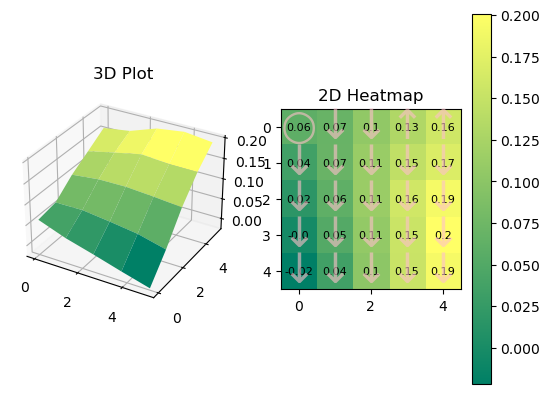

  2%|█▎                                                              | 1966/100000 [00:05<04:21, 375.03it/s]

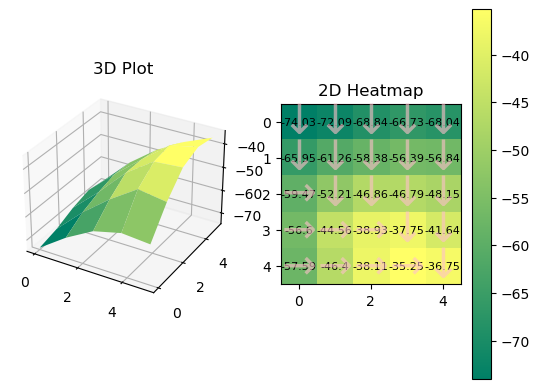

  3%|█▉                                                              | 2954/100000 [00:08<04:49, 335.29it/s]

KeyboardInterrupt



In [30]:
for _ in tqdm.tqdm(range(100000)):
    
    optimizer.zero_grad()
    
    batch = experiencePool.sample_batch(batch_size=batch_size)
    tmpstate, tmpaction, tmpscore, nextState, nextAction, terminal = batch

    tmpstate = tmpstate.reshape(batch_size,1)
    tmpstate = np.hstack((tmpstate // 5, tmpstate % 5))  #将state变成了行列
    nextState = nextState.reshape(batch_size,1)
    nextState = np.hstack((nextState // 5, nextState % 5))  #将state变成了行列

    tmpstate = torch.tensor(tmpstate,dtype = torch.float32).view(batch_size,2)
    nextState = torch.tensor(nextState,dtype = torch.float32).view(batch_size,2)

    # tmpaction = torch.tensor(tmpaction,dtype = torch.int).view(batch_size,1)
    # nextAction = torch.tensor(nextAction,dtype = torch.int).view(batch_size,1)

    tmpscore = torch.tensor(tmpscore,dtype = torch.float32).view(batch_size,1)
    terminal = torch.tensor(terminal,dtype = torch.float32).view(batch_size,1)

    with torch.no_grad():
        next_action_values = network(nextState)  #网络
        
        # b = [next_action_values[i,nextAction[i]] for i in range(batch_size)]
        # next_action_value = torch.tensor(b,dtype = torch.float32).view(batch_size,1)
        
        c = next_action_values.max(1)[0] #改成DQN了，这里就得取最大值
        next_action_value = torch.tensor(c,dtype = torch.float32).view(batch_size,1)
        
        target = tmpscore + (1.0 - terminal) * gamma * next_action_value

    #获得当前的action values
    now_action_values = network(tmpstate)    #网络
    now_action_value = now_action_values[0,tmpaction[0]]
    for i in range(1,batch_size):
        now_action_value = torch.cat((now_action_value.view(-1), now_action_values[i,tmpaction[i]].view(-1)),dim=0)
    
    now_action_value = now_action_value.view(-1,1)
    
    loss = F.mse_loss(now_action_value, target)
    loss.backward()
    optimizer.step()
            
    if _ % 2000 == 0:
        s = np.array([[i] for i in range(25)])
        s = np.hstack((s // 5, s % 5))
        states = torch.tensor(s, dtype = torch.float32).view(25,2)
        # 还原成state_values
        state_values = network(states).view(-1).detach().numpy()
        
        s = np.array([[i] for i in range(25)])
        s = np.hstack((s // 5, s % 5))
        states = torch.tensor(s, dtype = torch.float32).view(25,2)
        # 还原成action_values
        action_values = network(states).view(-1,5).detach().numpy()

        state_values = np.sum(policy * action_values,axis=1)

        
        p = np.argmax(action_values,axis=1)
        draw(state_values.reshape(5,5), p)